In [1]:
#!/usr/bin/env python

import sys
sys.path.insert(0,'/Users/cmdb/projects/ConfocalAnalysis')
sys.path.insert(0,'/Users/babygirljohnston/Documents/ConfocalAnalysis/ConfocalAnalysis')
sys.path.insert(0,'/Users/babygirljohnston/Documents/Confocal_Xiuqi/scikit-image')

from czifile import CziFile
import numpy as np
from math import sqrt
from skimage.feature import blob_log
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.cluster import DBSCAN
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
import operator


# pip install scikit-image # if not working, compile from source
# pip install -U scikit-learn

"""Useful Functions"""

def GetOneChannel( czi_file, channel ):
# this function takes the whole .czi file and return a single channel .czi
    stacknumber=czi_file.shape[3]
    OneChannel=[czi_file[0,channel,0,index].T[0].T for index in range(stacknumber)]
    return OneChannel

def FindBlobs( OneChannel,thresh=0.2 ):
# this function takes output from GetOneChannel (a single channel .czi file input)
# return all the blobs in a dict & a structured list & a flattened list
# Dict    # "Y,X,Z"->[radius, intensity]
# struct. List    # [[[Y,X,Z1],[Y,X,Z1]...],[[Y,X,Z2],[Y,X,Z2],...],...,[[Y,X,Zn],...]],np.array
# flat. List    # [[Y1,X1,Z1],[Y2,X2,Z2],[Y3,X3,Z3],...,[Yn,X3,Z3]]
  
    blobs_dict={}
    blobsAll=[]
    blobsList=[]
    stacknumber=len(OneChannel)
    
    for z in range(stacknumber):
        planeblobs=[]
        """Blob Recognition Parameters here"""
        log = blob_log(OneChannel[z], max_sigma=30, num_sigma=10,min_sigma =3, threshold=thresh)
        # Radius of the blob
        log[:, 2] = log[:, 2] * sqrt(2)
        # intensity
        blob_intensity=np.zeros(len(log[:,0]))
        
        for i in range(len(log[:,0])):
            blob_intensity[i]=OneChannel[z][int(log[i,0]),int(log[i,1])]
        
        for i in range(len(log[:,2])):
            position=np.append(log[i,0:2],z)
            position=map(int,position)
            blobs_dict["{},{},{}".format(position[0],position[1],position[2])]=[log[i,2],blob_intensity[i]]
            planeblobs.append(position)
        
        blobsAll.append(planeblobs)
    
    blobsAll=np.array(blobsAll)

    for z in range(len(blobsAll)):
        blobsList=blobsList+blobsAll[z]
    blobsList=np.array(blobsList)
    
    return blobs_dict,blobsAll,blobsList



def GetClustersOneChannel( blobsList ):
# this function takes the dict and flattened list from FindBlobs
# return the clusters
###  [[[cluster1_dot1],[cluster1_dot2],...],
#     [[cluster2_dot1],[cluster2_dot2]...],
#     [...],...,
#     [[clusterN_dot1],[clusterN_dot2]] ]

    """3D clustering of Blobs"""
    db = DBSCAN(eps=2, min_samples=2).fit(blobsList)
    labels = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    print('Estimated number of clusters: %d' % n_clusters_)
#     print("Silhouette Coefficient: %0.3f"
#           % metrics.silhouette_score(blobsList, labels))
    
    """Group up the dots within a cluster"""
    clusters=[]
    for i in range(n_clusters_):
        cluster=[]
        ## Extract X,Y,Z location of the points based on clusters
        positions=np.argwhere(labels==i)
        for j in range(len(positions)):
            cluster.append(blobsList[positions[j]])
        clusters.append(cluster)

    return clusters

def SignalPositionsOneChannel( clusters,blobs_dict ):
# This function takes the clusters List from GetClustersOneChannel
# return the calculated signal position in this one channel all stacks
# [[Y,X,Z,avgIntensity],[Y,X,Z,avgIntensity],...,[Y,X,Z,avgIntensity]]
    """Find the actual signal location"""
    signals=[]
    for i in range(len(clusters)):
        signal=[]
        dots=[]
        ## extract the intensity of the dot in the cluster (from the dictionary)
        for j in range(len(clusters[i])):
            #print clusters[i][j][0]
            dot=clusters[i][j][0]
            intensity=blobs_dict["{},{},{}".format(clusters[i][j][0][0],clusters[i][j][0][1],clusters[i][j][0][2])][1]
            dot=np.append(dot,intensity)
            dots.append(dot)
        # Calculating the actual dot location
        intensity_sum=sum(dots[index][3] for index in range(len(dots)))
        avgIntensity=intensity_sum/len(dots)
        y=sum(dots[index][0]*dots[index][3]/intensity_sum for index in range(len(dots)))
        x=sum(dots[index][1]*dots[index][3]/intensity_sum for index in range(len(dots)))
        z=sum(dots[index][2]*dots[index][3]/intensity_sum for index in range(len(dots)))
        signal=[y,x,z,avgIntensity]
        signals.append(signal)
    signals=np.array(signals)
    return signals

def ToActualScale(list):
# This function takes a [n_sample,[Y,X,Z,Intensity]] LIST
# convert to the actual scale of the coordinates
    """Adjust Parameters"""
    # 63X objective, unit: um
    x_scale=0.099
    y_scale=0.099
    z_scale=0.2
    actual=np.zeros((len(list),4))
    for i in range(len(list)):
        actual[i][0]=list[i][0]*y_scale
        actual[i][1]=list[i][1]*x_scale
        actual[i][2]=list[i][2]*z_scale
        actual[i][3]=list[i][3]
    return actual

def GetDistance(element1,element2):
# This function takes two [Y,X,Z]
# return euclidean distance
    distance=sqrt((element1[0]-element2[0])**2+(element1[1]-element2[1])**2+(element1[2]-element2[2])**2)
    return distance

def FindPairs( signals1,signals2 ):
# This function takes 2 signals-Lists generated in SignalPositionsOneChannel
# return pairs  (LIST)
# [[sig1_1,sig2_N1],[sig1_2,sig2_N2],...,[sig1_N,sig2_Nn]]
    pairs=[]
    signals1=ToActualScale(signals1)
    signals2=ToActualScale(signals2)
    #print signals1
    #print signals2
    # empirically, distance between 2 dots won't exceed 1.2 microns
    """Adjust Parameters"""
    limit=1.2
    
    # Brute-Force solve
    for i in range(len(signals1)):
        distances=[]
        for j in range(len(signals2)):
            if signals2[j][0]==0:
                distances.append(100)  # rule out the past dots
                continue
            distance=GetDistance(signals1[i],signals2[j])
            distances.append(distance)
        min_index, min_value = min(enumerate(distances), key=operator.itemgetter(1))
        if min_value>limit:
            continue
        pairs.append([i,min_index,min_value])
        signals2[min_index]=[0,0,0,0]
#         print signals2[min_index]
#         print signals2
    return pairs


tifffile.py:306: UserWarning: ImportError: No module named '_tifffile'. Loading of some compressed images will be very slow. Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "ImportError: No module named '_tifffile'. "
czifile.py:130: UserWarning: failed to import the optional _czifile C extension module.
Decoding of JXR and JPEG encoded images will not be available.
Czifile.pyx can be obtained at http://www.lfd.uci.edu/~gohlke/
  "failed to import the optional _czifile C extension module.\n"


In [2]:
# Main function
""" Image Input """
with CziFile('/Users/babygirljohnston/Documents/Confocal_Xiuqi/Image_1.czi') as czi:
    image_arrays=czi.asarray()


    
# 63X objective, unit: um

In [ ]:
## Plot the image

colomap=["Blues","gray","Greens_r","Reds_r"]
labell=['yellow','yellow','green','red']
channel=2
stack=5
# Images[stack#, Y, X]
images=[np.array(image_arrays[0,channel,0,index].T[0].T) for index in range(26)]
#print len(images)
# Show the map
fig=plt.figure()
mapp=plt.imshow(images[stack],cmap=colomap[channel])

cbar = fig.colorbar(mapp, ticks=[0, 65535])
cbar.ax.set_yticklabels(['0', '65535'])

plt.show()  



In [3]:
"""Image Processing"""
# Get one channel for ss
OneChannel_ss=GetOneChannel(image_arrays,2)
blobs_dict_ss,blobsAll_ss,blobsList_ss=FindBlobs(OneChannel_ss)
# Get one channel for klu

# OneChannel_klu=GetOneChannel(image_arrays,3)
# blobs_dict_klu,blobsAll_klu,blobsList_klu=FindBlobs(OneChannel_klu)

In [ ]:
"""Check the blobs"""





In [12]:
"""Analyze the blobs"""
clusters_ss=GetClustersOneChannel(blobsList_ss)
clusters_klu=GetClustersOneChannel(blobsList_klu)

Estimated number of clusters: 519
Estimated number of clusters: 506


In [13]:
#print clusters_ss
signals_ss=SignalPositionsOneChannel(clusters_ss,blobs_dict_ss)
signals_klu=SignalPositionsOneChannel(clusters_klu,blobs_dict_klu)

In [17]:
#######plot the two signals
y_s,x_s,z_s,i_s = ToActualScale(signals_ss).T
y_k,x_k,z_k,i_k = ToActualScale(signals_klu).T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_s, y_s, z_s,color='green')
ax.scatter(x_k, y_k, z_k,color='red')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_zlim([-1,6])

plt.show()

# print len(blobsList)
# print blobsList


AttributeError: 'module' object has no attribute '_string_to_bool'

In [18]:
pairs=FindPairs(signals_ss,signals_klu)

# print signals_ss
# print signals_klu

print len(pairs)
print pairs
# for pair in pairs:
#     print signals_ss[pair[0]][0:3],signals_klu[pair[1]][0:3]


122
[[12, 11, 0.7187778764481403], [21, 15, 0.6960498677935472], [23, 16, 0.7028000144730208], [27, 21, 0.33180820992794813], [32, 29, 1.1066845480509409], [35, 30, 0.30353642136954023], [38, 69, 1.0440600438994525], [46, 37, 0.2894034213231929], [51, 42, 0.2672488899036428], [53, 43, 0.4725049280138748], [55, 45, 0.5346644115381165], [63, 50, 0.35201403434029627], [64, 51, 0.9255457804438347], [66, 4, 0.37166885479977624], [67, 5, 0.3101130635364421], [70, 57, 0.5350533624387155], [71, 62, 0.3660998397420356], [72, 18, 0.5954409708882533], [79, 74, 0.45519423904289], [80, 75, 0.31420672427717816], [81, 46, 0.7057328424461804], [83, 48, 0.44927609965190896], [92, 166, 0.6762628224294199], [109, 156, 1.0688467355637221], [110, 97, 0.3626293893413301], [111, 130, 0.37639298625052636], [116, 78, 0.3511977628414332], [120, 80, 0.9254154723369872], [128, 149, 0.5965636186747562], [135, 125, 0.4999158388153742], [137, 157, 0.09079213249092039], [140, 101, 0.39687140773113905], [147, 141, 0.9

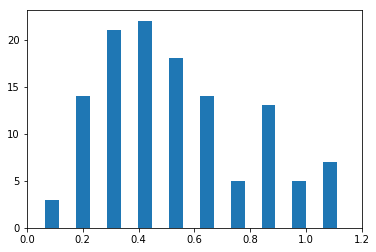

In [19]:

distances=[pairs[index][2] for index in range(len(pairs))]
hist, bin_edges=np.histogram(distances,bins=10)
plt.bar(bin_edges[:-1],hist,width=0.05)
plt.xlim(0, 1.2)
plt.show()


In [20]:
# extract the long ones
long=[]
for pair in pairs:
    #print pair
    if pair[2]>0.8:
        long.append(pair[0:3])

pair_coord=[]
for pair in long:
    pair_coord.append([signals_ss[pair[0]][0:3],signals_klu[pair[1]][0:3]])

#print pair_coord

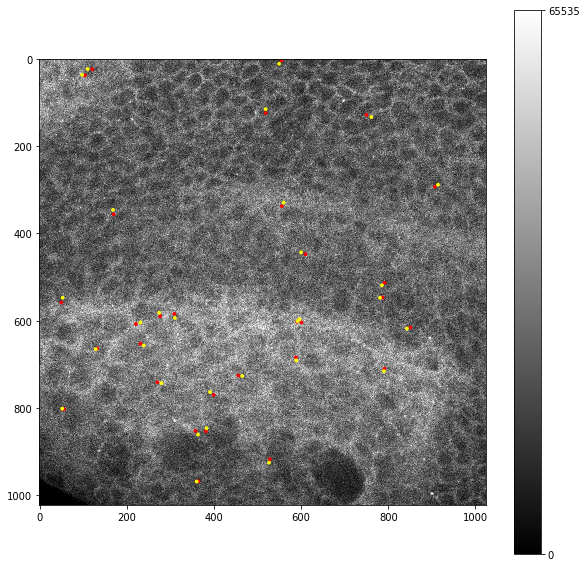

In [21]:
## plot long ones with image


colomap=["Blues","gray","Greens_r","Reds_r"]
labell=['yellow','yellow','red','yellow']
## Extract Channel 1 -- Z-stack
channel=1

stack=0

# lamin channel
OneChannel_lamin=GetOneChannel(image_arrays,1)


# Show the map
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,10))
mapp=plt.imshow(OneChannel_lamin[stack],cmap=colomap[channel])

cbar = fig.colorbar(mapp, ticks=[0, 65535])
cbar.ax.set_yticklabels(['0', '65535'])

for pair in long:
    ss, klu, distance= pair
    s = plt.Circle((signals_ss[ss][1], signals_ss[ss][0]), 2, color=labell[2], linewidth=2, fill=False)
    axes.add_patch(s)
    k = plt.Circle((signals_klu[klu][1], signals_klu[klu][0]), 2, color=labell[3], linewidth=2, fill=False)
    axes.add_patch(k)
plt.show()





In [22]:
## 3D plot

print pair_coord
y_s,x_s,z_s = np.array([pair_coord[index][0] for index in range(len(pair_coord))]).T
y_k,x_k,z_k = np.array([pair_coord[index][1] for index in range(len(pair_coord))]).T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_s, y_s, z_s,color='green')
ax.scatter(x_k, y_k, z_k,color='red')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_zlim([-5,30])

plt.show()

[[array([  4.48000000e+02,   6.10000000e+02,   5.04376807e-01]), array([ 443.48087045,  599.97850758,    1.50777083])], [array([ 356.44453452,  169.82087147,    1.61174167]), array([ 346.        ,  168.41575788,    1.41575788])], [array([  3.47821810e+00,   5.55000000e+02,   4.78218100e-01]), array([  1.10000000e+01,   5.49448248e+02,   4.48248335e-01])], [array([ 123.87309508,  518.60834877,    2.87309508]), array([ 115.        ,  518.58673169,    5.91767318])], [array([ 726.        ,  456.        ,    4.06759318]), array([ 727.30407876,  465.        ,    2.99702083])], [array([ 584.36250766,  309.29750625,    5.02252157]), array([ 594.        ,  310.47726056,    4.47726056])], [array([ 293.        ,  907.        ,    4.44078947]), array([ 288.52585927,  914.        ,    2.52585927])], [array([  23.4971422,  121.       ,    4.4971422]), array([  23.        ,  110.42673067,    3.42673067])], [array([ 968.51192683,  364.48807317,    5.51192683]), array([ 969.25906772,  360.32044529,    

AttributeError: 'module' object has no attribute '_string_to_bool'